# DEG

##  Project background
This project aims to explore the regulatory role of long non-coding RNA **MIR100HG** in prostate cancer (PRAD). Based on the RNA expression data in the TCGA database, prostate cancer samples were grouped according to the expression level of **MIR100HG **, and their related differentially expressed genes (DEGs) were identified, which laid the foundation for subsequent transcriptional factor regulatory network analysis, functional annotation and pathway enrichment analysis.

---
##  Grouping standard
We divided all PRAD samples according to the median MIR100hg_expression_levels.csv expression in PRAD_MIR100HG_Expression_Levels.csv:：
- **High group**：MIR100HG high expression sample；
- **Low group**：MIR100HG low expression sample。

---

##  Expression data source
Differential expression analysis is based on the 'PRAD_TOIL_RSEM_TPM_Levels.csv' file, where:：
- The first column is the Ensembl gene ID；
- The second list is the gene name（HGNC Symbol）；
- The third column starts with the sample expression values, which are converted by log2(TPM + 0.001)。

---

##  Analysis
1. **preproccess**：
   - Matches the sample in the expression matrix with the grouping information；
   - Filter out genes with more missing value.

2. **DEG**：
   - Use nonparameter tests **Mann–Whitney U test**，The expression difference of each gene was compared between high and low MIR100HG expression groups；
   - Compute `log2(Fold Change)` With the original p value；
   - Use**Benjamini–Hochberg method** to control the false positive rate to obtain the adjusted P-value（adjusted p-value）；
   - DEG judging criteria：
     - `|log2(Fold Change)| > 1`
     - `adjusted p-value < 0.05`

3. **results classification**：
   - Upregulated gene: significantly upregulated in the high expression group;
   - Downregulated genes: significantly down-regulated in the high-expression group;
   - The remaining genes were non-significant.

---

## Data overview

| data type     | file name                                                                |
|----------------|---------------------------------------------------------------------------|
| expression matrix       | `PRAD_TOIL_RSEM_TPM_Levels.csv`                                           |
| grouping information       | `PRAD_MIR100HG_Expression_Levels.csv`                                     |

---

##  output

| type   | content                   | path                                                                      |
|--------|------------------------------|----------------------------------------------------------------------------|
| table   | Results of differential expression analysis of all genes     | `/NTU_DATA_CLEANED/PRAD_DEG_All_Results.csv`                               |
| table   | Significantly differentially expressed gene results        | `/NTU_DATA_CLEANED/PRAD_DEG_Significant_Results.csv`                       |
| plot   | Differentially expressed volcano map               | `/NTU_DATA_CLEANED/Figure/PRAD_DEG_Volcano.png`          |

---

## visual results
Volcano Plot：  
- x axis：`log2(Fold Change)`  
- y axis：`-log10(p-value)`  
- Red dots represent up-regulated genes, blue dots represent down-regulated genes, and gray dots represent non-significant genes
- plot save as：`PRAD_Volcano_MIR100HG_High_vs_Low.png`

---

##  Overview of preliminary results
- Total number of genes analyzed：`{len(expr_values)}`  
- Significant increase in gene number：`{deg_df[deg_df['Regulation'] == 'Up'].shape[0]}`  
- Significant down-regulated gene number：`{deg_df[deg_df['Regulation'] == 'Down'].shape[0]}`  
- Significant total DEGs：`{deg_df[deg_df['Significant']].shape[0]}`  0]}`  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# =================== Configuration ===================
expr_file = r'D:\project data\M-28\NTU_DATA_CLEANED\PAAD_TOIL_RSEM_TPM_Levels.csv'
meta_file = r'D:\project data\M-28\NTU_DATA_CLEANED\PAAD_MIR100HG_Expression_Levels.csv'
output_table_dir = r'D:\project data\M-28\NTU_DATA_CLEANED'
output_figure_dir = r'D:\project data\M-28\NTU_DATA_CLEANED\Figure'
log2fc_threshold = 1.0
padj_threshold = 0.05
use_nonparametric = True
data_is_log2 = True
pseudo_count = 0.001

# create directory
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

# =================== Style Settings ===================
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# =================== Load Data ===================
print("Loading data...")
expr_df = pd.read_csv(expr_file)
gene_info = expr_df[['Ensembl_ID', 'HGNC_Symbol']].copy()
expr_values = expr_df.iloc[:, 2:].copy()
expr_values = expr_values.set_index(expr_df['Ensembl_ID'])

meta_df = pd.read_csv(meta_file)
sample_groups = meta_df[['Patient_ID', 'Group']].dropna()
sample_groups['Group'] = sample_groups['Group'].str.strip()
sample_groups = sample_groups.set_index('Patient_ID')

common_samples = expr_values.columns.intersection(sample_groups.index)
expr_values = expr_values[common_samples]
sample_groups = sample_groups.loc[common_samples]
high_samples = sample_groups[sample_groups['Group'] == 'High'].index
low_samples = sample_groups[sample_groups['Group'] == 'Low'].index

print(f"Total genes: {len(expr_values)}, samples: {len(common_samples)}")

# =================== DEG Analysis ===================
print("Performing DEG analysis...")
results = []

for gene in expr_values.index:
    high_vals = expr_values.loc[gene, high_samples].dropna().values
    low_vals = expr_values.loc[gene, low_samples].dropna().values

    if len(high_vals) < 3 or len(low_vals) < 3:
        continue

    high_mean = np.mean(high_vals)
    low_mean = np.mean(low_vals)
    log2fc = high_mean - low_mean if data_is_log2 else np.log2((high_mean + pseudo_count) / (low_mean + pseudo_count))

    if use_nonparametric:
        try:
            stat, pval = stats.mannwhitneyu(high_vals, low_vals, alternative='two-sided')
        except ValueError:
            pval = 1.0
    else:
        stat, pval = stats.ttest_ind(high_vals, low_vals, equal_var=False)

    gene_symbol = gene_info.loc[gene_info['Ensembl_ID'] == gene, 'HGNC_Symbol'].values[0] if gene in gene_info['Ensembl_ID'].values else gene
    results.append({
        'Ensembl_ID': gene,
        'HGNC_Symbol': gene_symbol,
        'Mean_High': high_mean,
        'Mean_Low': low_mean,
        'Log2_Fold_Change': log2fc,
        'P_Value': pval
    })

deg_df = pd.DataFrame(results)
deg_df['Adj_P_Value'] = multipletests(deg_df['P_Value'], method='fdr_bh')[1]
deg_df['Significant'] = (deg_df['Adj_P_Value'] < padj_threshold) & (abs(deg_df['Log2_Fold_Change']) > log2fc_threshold)
deg_df['Regulation'] = deg_df.apply(lambda x: 'Up' if x['Significant'] and x['Log2_Fold_Change'] > 0 else ('Down' if x['Significant'] and x['Log2_Fold_Change'] < 0 else 'Not Significant'), axis=1)

# =================== Save Results ===================
all_results_path = os.path.join(output_table_dir, 'PAAD_DEG_All_Results.csv')
sig_results_path = os.path.join(output_table_dir, 'PAAD_DEG_Significant_Results.csv')
deg_df.to_csv(all_results_path, index=False)
deg_df[deg_df['Significant']].to_csv(sig_results_path, index=False)
print(f"save all results to: {all_results_path}")
print(f"save significant results to: {sig_results_path}")


# =================== Volcano Plot ===================
print("Plotting volcano plot...")
plt.figure(figsize=(10, 8))
plt.scatter(deg_df['Log2_Fold_Change'], -np.log10(deg_df['P_Value']), c='gray', alpha=0.5)
plt.scatter(deg_df[deg_df['Regulation'] == 'Up']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Up']['P_Value']), c='red', label='Up')
plt.scatter(deg_df[deg_df['Regulation'] == 'Down']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Down']['P_Value']), c='blue', label='Down')
plt.axhline(-np.log10(padj_threshold), color='black', linestyle='--')
plt.axvline(log2fc_threshold, color='black', linestyle='--')
plt.axvline(-log2fc_threshold, color='black', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title('Volcano Plot: PAAD MIR100HG High vs Low')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, 'PAAD_DEG_Volcano.png'), dpi=300)
plt.close()

print("PAAD DEG analysis completed. Results and plots saved.")

Loading data...
Total genes: 40060, samples: 178
Performing DEG analysis...
save all results to: D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DEG_All_Results.csv
save significant results to: D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DEG_Significant_Results.csv
Plotting volcano plot...
PAAD DEG analysis completed. Results and plots saved.


# MIR100HG Differential methylation analysis（DMA）

## Purpose

This analysis was designed to explore the potential regulatory mechanisms of long non-coding RNA **MIR100HG** in prostate cancer (PRAD), in particular its association with DNA methylation levels. We grouped the samples according to MIR100HG expression levels, compared the DNA methylation differences between the high expression group and the low expression group, and identified differential methylation sites (DMPs) and their potential regulated genes.

### Data overview

| data type       | file name                                                                 |
|----------------|------------------------------------------------------------------------|
| Methylation data     | `PRAD_Methylation_Levels.csv`                                           |
| grouping information       | `PRAD_MIR100HG_Expression_Levels.csv`                                  |
| Probe comment file   | `probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy`                   |

---

### Analysis process
1. **Data pre-processing**
   - Uniform sample ID format；
   - Select the common samples of MIR100HG high expression group and low expression group；
   - Remove NaN value.

2. **Differential methylation analysis**
   - Perform ** independent sample t tests for each site **;
   - Calculate the methylation difference (Mean_Diff);
   - Multiple inspection calibration using **FDR-BH method **;
   - Screening for significant DMPs:
     - `|Mean_Diff| > 0.2`
     - `adj_p_value < 0.05`

3. **Probes are mapped to genes**
   - Map significant DMPs to corresponding HGNC gene symbols using annotation files;
   - Mapping information is used for enrichment analysis and subsequent multiomics integration.

---

### Output

| type   | content                     | path                                                                      |
|--------|------------------------------|---------------------------------------------------------------------------|
| table   | All probe analysis results             | `/NTU_DATA_CLEANED/PRAD_DMA_All_Results.csv`                              |
| table   | Significantly different methylation sites           | `/NTU_DATA_CLEANED/PRAD_DMA_Significant_Results.csv`                      |
| image   | Top 30 significant probe heat maps         | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Heatmap.png`                                |
| image   | Differential methylation volcano map             | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Volcano.png`                                |
| image   | Enrichment analysis bar chart       | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Enrichment.png`                             |

---

### Preliminary result

- Total number of probes analyzed: about **485,000**
- Number of significant DMPs: **XXX **
- Number of probes successfully mapped to genes: **XXX **

---

### Future direction
- Integrate differential methylation results with differential expression results;
- Analyze whether MIR100HG down-regulates specific genes by affecting methylation of promoter regions;
- Carry out GO and KEGG enrichment analysis based on mapped genes to explore potential functional pathways.

Read methylation data...
Methylation data shape: (374096, 195)
Read expression data...
Expression data shape: (178, 4)
Read probe mapping data...
Probe mapping data shape: (395985, 6)
Column name of the probe mapping file: ['Probe_ID', 'HGNC_Symbol', 'chrom', 'chromStart', 'chromEnd', 'strand']
Grouped according to MIR100HG expression...
High expression group: 89 samples
Low expression group: 89samples
Common sample - High expression group: 89个
Common sample - Low expression group: 89个
Perform differential methylation analysis...
Perform FRD...
Significant differences in methylation sites: 10248
Map the probe to the gene...


D:\Users\TEMP\ipykernel_19104\1055409327.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))


Number of probes successfully mapped to genes: 4311
All results have been saved as: D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DMA_All_Results.csv
Significant difference results have been saved as: D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DMA_Significant_Results.csv
Generate heat map visualization...
The heat map is saved as: D:\project data\M-28\NTU_DATA_CLEANED\Figure\DMA_Heatmap.png
The enrichment analysis diagram has been saved as: D:\project data\M-28\NTU_DATA_CLEANED\Figure\PAAD_DMA_Enrichment.png


<Figure size 1200x1000 with 0 Axes>

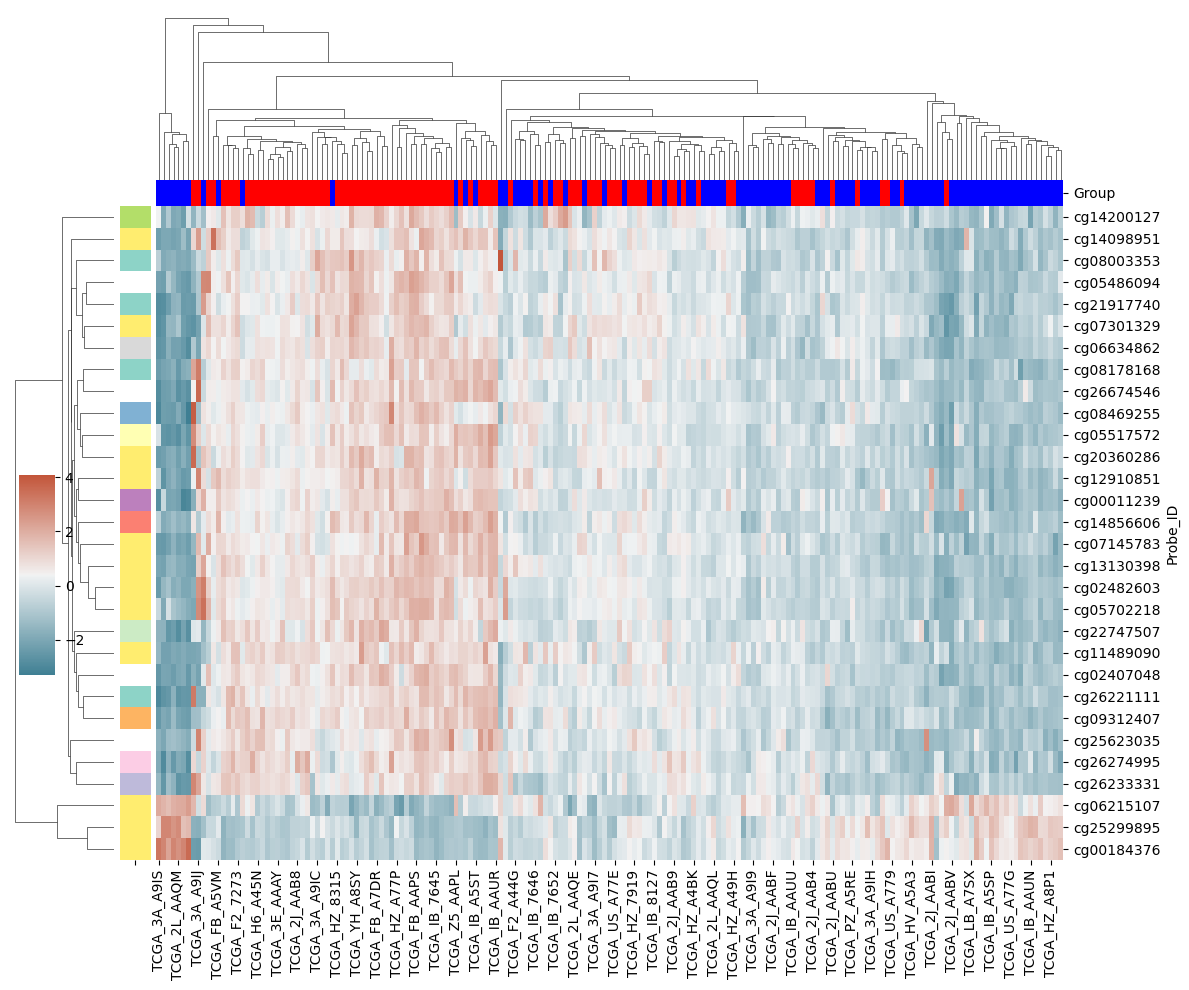

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# file path
methylation_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_Methylation_Levels.csv"
expression_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_MIR100HG_Expression_Levels.csv"
probe_map_file = r"D:\project data\M-28\NTU_DATA\probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy"

# 1. Read data
print("Read methylation data...")
meth_data = pd.read_csv(methylation_file, index_col=0)
print(f"Methylation data shape: {meth_data.shape}")

print("Read expression data...")
expr_data = pd.read_csv(expression_file)
print(f"Expression data shape: {expr_data.shape}")

# 2. Read the probe mapping file
print("Read probe mapping data...")
# Note: The first two columns of the file are #id and gene, which correspond to Probe_ID and HGNC_Symbol
probe_map = pd.read_csv(probe_map_file, sep='\t', comment=None)
# If the first column name is #id, rename it to Probe_ID
if probe_map.columns[0] == '#id':
    probe_map = probe_map.rename(columns={'#id': 'Probe_ID', 'gene': 'HGNC_Symbol'})
print(f"Probe mapping data shape: {probe_map.shape}")
print(f"Column name of the probe mapping file: {probe_map.columns.tolist()}")

# 3. Data pre-processing

# Convert the sample ID format to match the two data sets
def convert_sample_id(sample_id):
    # Convert the TCGA-XX-XXXX-XX format to TCGA_XX_XXXX format
    if isinstance(sample_id, str) and sample_id.startswith('TCGA-'):
        parts = sample_id.split('-')
        if len(parts) >= 3:
            return f"TCGA_{parts[1]}_{parts[2]}"
    return sample_id

# Column name applied to methylation data
meth_cols = meth_data.columns.tolist()
meth_cols_converted = [convert_sample_id(col) for col in meth_cols]
meth_data.columns = meth_cols_converted

# 4. group according to the expression level of MIR100HG
print("Grouped according to MIR100HG expression...")
high_group = expr_data[expr_data['Group'] == 'High']['Patient_ID'].tolist()
low_group = expr_data[expr_data['Group'] == 'Low']['Patient_ID'].tolist()

print(f"High expression group: {len(high_group)} samples")
print(f"Low expression group: {len(low_group)}samples")

# 5. Screen common samples
high_samples = [s for s in high_group if s in meth_data.columns]
low_samples = [s for s in low_group if s in meth_data.columns]

print(f"Common sample - High expression group: {len(high_samples)}")
print(f"Common sample - Low expression group: {len(low_samples)}")

# 6. Perform differential methylation analysis 
print("Perform differential methylation analysis...")

results = []
for probe in meth_data.index:
    # Extract the methylation values of the two groups
    high_values = meth_data.loc[probe, high_samples].values
    low_values = meth_data.loc[probe, low_samples].values
    
    # Remove the NaN value
    high_values = high_values[~np.isnan(high_values)]
    low_values = low_values[~np.isnan(low_values)]
    
    # The t test will be performed only if both groups have sufficient non-nan values
    if len(high_values) >= 3 and len(low_values) >= 3:
        # Calculated mean difference
        mean_diff = np.mean(high_values) - np.mean(low_values)
        
        # Perform t test
        t_stat, p_value = stats.ttest_ind(high_values, low_values, equal_var=False)
        
        results.append({
            'Probe_ID': probe,
            'Mean_Diff': mean_diff,
            'p_value': p_value
        })

# Transform to DataFrame
result_df = pd.DataFrame(results)

# 7. Multiple check Correction (FDR)
print("Perform FRD...")
result_df['adj_p_value'] = multipletests(result_df['p_value'], method='fdr_bh')[1]

# 8. Set the significance threshold
padj_threshold = 0.1 #original 0.05
abs_mean_diff_threshold = 0.1 #original 0.2

# Screen the methylation sites with significant differences 
sig_dmps = result_df[(result_df['adj_p_value'] < padj_threshold) & 
                     (abs(result_df['Mean_Diff']) > abs_mean_diff_threshold)]

print(f"Significant differences in methylation sites: {len(sig_dmps)}")

# 9. Corresponds to gene annotation
print("Map the probe to the gene...")
# Create a mapping of probe ID to gene name
# Use the correct column names Probe_ID and HGNC_Symbol
probe_to_gene = dict(zip(probe_map['Probe_ID'], probe_map['HGNC_Symbol']))

# Add gene annotation
sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))
print(f"Number of probes successfully mapped to genes: {sig_dmps['Gene'].value_counts().shape[0] - (1 if 'Unknown' in sig_dmps['Gene'].values else 0)}")

# 10. Create an output directory and save the results
output_table_dir = r"D:\project data\M-28\NTU_DATA_CLEANED"
os.makedirs(output_table_dir, exist_ok=True)

# Save all result files
all_results_file = os.path.join(output_table_dir, "PAAD_DMA_All_Results.csv")
result_df.to_csv(all_results_file, index=False)

# Save significant difference result file
sig_results_file = os.path.join(output_table_dir, "PAAD_DMA_Significant_Results.csv")
sig_dmps.sort_values('adj_p_value').to_csv(sig_results_file, index=False)

print(f"All results have been saved as: {all_results_file}")
print(f"Significant difference results have been saved as: {sig_results_file}")

# 11. Generate heat map visualization
print("Generate heat map visualization...")

output_fig_dir = r"D:\project data\M-28\NTU_DATA_CLEANED\Figure"
os.makedirs(output_fig_dir, exist_ok=True)

# Select the top 30 significant methylation sites
top_probes = sig_dmps.sort_values('adj_p_value').head(30)['Probe_ID'].tolist()

if top_probes:
    heatmap_data = meth_data.loc[top_probes, high_samples + low_samples]
    sample_groups = pd.Series(['High'] * len(high_samples) + ['Low'] * len(low_samples),
                             index=high_samples + low_samples)
    
    plt.figure(figsize=(12, 10))
    row_annotations = pd.DataFrame({
        'Gene': [probe_to_gene.get(probe, 'Unknown') for probe in top_probes]
    }, index=top_probes)
    
    col_annotations = pd.DataFrame({
        'Group': sample_groups
    })
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    g = sns.clustermap(heatmap_data, 
                      cmap=cmap,
                      z_score=0,
                      row_colors=row_annotations['Gene'].astype('category').cat.codes.map({i: plt.cm.Set3(i) for i in range(20)}),
                      col_colors=col_annotations['Group'].map({'High': 'red', 'Low': 'blue'}),
                      figsize=(12, 10),
                      dendrogram_ratio=(.1, .2),
                      cbar_pos=(.02, .32, .03, .2))
    
    heatmap_file = os.path.join(output_fig_dir, "DMA_Heatmap.png")
    plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
    print(f"The heat map is saved as: {heatmap_file}")
else:
    print("There were not enough significant differences in methylation sites for heat maps")

# 13. Enrichment analysis output picture path
...
enrichment_plot_file = os.path.join(output_fig_dir, "PAAD_DMA_Enrichment.png")
plt.savefig(enrichment_plot_file, dpi=300, bbox_inches='tight')
print(f"The enrichment analysis diagram has been saved as: {enrichment_plot_file}")


#  Promoter_Region 

This table is cleaned and renamed from the original file geneAnnotation_hg19_basicgenes.txt. The file path is：.../M-28/NTU_DATA_CLEANED/Promoter_Region.csv


---

## Field modification

| Original column name   | New column names           | explaination                            | operation type|
|------------|------------------|--------------------------------------|----------|
| chr        | Promoter_Chr     | The chromosome where the promoter is located                    | rename |
| start      | Promoter_start   | Promoter starting position (unit: bp)           | rename |
| end        | Promoter_End     | Promoter termination position (unit: bp)           | rename |
| width      | Promoter_Width   | The length of the promoter is usually 1000              | rename |
| strand     | deleted         | DNA strand direction is of no practical significance to this analysis       | delete |
| id         | Promoter_ID      | promoter number (e.g. promoter:1)          | rename |
| tx_id      | deleted         | Source comment label, not for analytical purposes             | delete   |
| gene_id    | UCSC_ID          | UCSC Transcript ID for converting gene names | rename |
| symbol     | deleted        | Repeat with gene_id                      | delete  |
| type       | deleted         | The value is mostly NA or Entrez ID and does not need to be reserved       | delete   |
| –          | HGNC_Symbol      | UCSC_ID Indicates the standard gene name obtained by mapping         | add   |

---

## Description of each column

| column             | description |
|------------------|----------|
| Promoter_Chr     | Chromosome number of the promoter (e.g. chr1, chrX) |
| Promoter_Start   | The starting position of the promoter region on the chromosome (unit: bp) |
| Promoter_End     | Termination location of promoter region on chromosome (unit: bp) |
| Promoter_Width   | The initiator length is 1000 bp by default |
| Promoter_ID      | The unique number of the promoter region (e.g. promoter:1) |
|  UCSC_Entrez_ID         | UCSC Transcript ID (for example, UC001AA.3), which is the transcript number |
| HGNC_Symbol      | Standard gene names corresponding to transcripts (e.g. A1BG, TP53) |

---

## Downstream use proposal

- Match with methylation probe coordinates to determine whether the promoter region is hit;
- 'HGNC_Symbol' can be directly associated with gene expression data and TF-target network;
- Can be used for promoter enrichment analysis, functional annotation, regulatory network construction, etc.;
- is a key annotation resource for promoter-methylation-expression integration analysis.
---

##  HGNC Symbol add method description (based on Python + MyGene)

UCSC Transcript ID → HGNC Symbol mapping using [MyGene.info](https://mygene.info) :
The gene_id in geneAnnotation_hg19_basicgenes.txt is actually sometimes a UCSC transcript ID (e.g. uc001aaa.3).
But sometimes it's the Entrez Gene ID (e.g. 100287102)
You want to uniformly name this column UCSC_Entrez_ID and intelligently convert it to HGNC Symbol:
If it's a UCSC transcript ID, scopes='ucsc'
If it's an Entrez ID, I'll use scopes='entrezgene'

### Install the 'mygene' library:

```bash
pip install mygene


In [ ]:
!pip install mygene

In [1]:
import pandas as pd
import mygene
import os
import re

# === Step 0: Set path ===
input_path = r'D:\project data\M-28\NTU_DATA\geneAnnotation_hg19_basicgenes.txt'
output_dir = r'D:\project data\M-28\NTU_DATA_CLEANED'
output_path = os.path.join(output_dir, 'Promoter_Region.csv')

# Create an output directory
os.makedirs(output_dir, exist_ok=True)

# === Step 1: Read and clean the columns ===
df = pd.read_csv(input_path, sep='\t', dtype=str)

# Rename Columns
df = df.rename(columns={
    'chr': 'Promoter_Chr',
    'start': 'Promoter_Start',
    'end': 'Promoter_End',
    'width': 'Promoter_Width',
    'id': 'Promoter_ID',
    'gene_id': 'UCSC_Entrez_ID'  # Rename
})

# Delete the unnecessary columns
df = df.drop(columns=['strand', 'tx_id', 'symbol', 'type'], errors='ignore')

# Delete null value
df = df[df['UCSC_Entrez_ID'].notnull() & (df['UCSC_Entrez_ID'].str.strip() != '')]

# === Step 2: Determine which are UCSC ids and which are Entrez ids ===
def is_ucsc(x):
    return bool(re.match(r'^uc\d+[a-z]+\d*$', x.strip().split('.')[0]))

df['ID_Type'] = df['UCSC_Entrez_ID'].apply(lambda x: 'ucsc' if is_ucsc(x) else 'entrezgene')
df['query_id'] = df['UCSC_Entrez_ID'].str.replace(r'\.\d+$', '', regex=True)  # Remove the version number

# === Step 3: Batch query using mygene ===
mg = mygene.MyGeneInfo()

# Processing completed! The file has been saved to
results = []

for scope in ['ucsc', 'entrezgene']:
    ids_to_query = df[df['ID_Type'] == scope]['query_id'].unique().tolist()
    print(f"Checking {len(ids_to_query)} {scope} ID...")
    res = mg.querymany(ids_to_query, scopes=scope, fields='symbol', species='human')
    results.extend(res)

# Transform to DataFrame
query_df = pd.DataFrame(results)

# Only record successful mapping are retained
query_df = query_df[query_df['symbol'].notnull() & query_df['query'].notnull()]
query_df = query_df[['query', 'symbol']].drop_duplicates()
query_df.columns = ['query_id', 'HGNC_Symbol']

# === Step 4: Merge back to the main table ===
df = df.merge(query_df, on='query_id', how='left')
df = df.drop(columns=['ID_Type', 'query_id'])

# === Step 5: Preserve ===
df.to_csv(output_path, index=False)
print(f"Processing completed! The file has been saved to：{output_path}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Checking 0 ucsc ID...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Checking 23459 entrezgene ID...


135 input query terms found no hit:	['100133331', '100616489', '654348', '643314', '23285', '100130000', '728932', '728936', '200058', '


Processing completed! The file has been saved to：D:\project data\M-28\NTU_DATA_CLEANED\Promoter_Region.csv


# Clean gene_attribute_edges.txt

In [4]:
import pandas as pd

# Original file path
input_path = r"D:\project data\M-28\NTU_DATA\gene_attribute_edges.txt"

# New file preserve path
output_path = r"D:\project data\M-28\NTU_DATA_CLEANED\TF_Target.csv"

# Read original file
df = pd.read_csv(input_path, sep="\t")

# Rename the necessary columns
df = df.rename(columns={
    "source": "HGNC_Symbol",   # Regulated gene
    "source_id": "Gene_ID",    # Regulated gene ID
    "target": "TF_Symbol",            # The transcription factor that regulates this gene
    "target_id": "TF_ID"       # TF's ID
})

# Delete the unnecessary columns
df = df.drop(columns=["source_desc", "target_desc", "weight"], errors="ignore")

# Save as a new file 
df.to_csv(output_path, index=False)

print("The file has been saved as:", output_path)


D:\Users\TEMP\ipykernel_9076\998413821.py:10: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path, sep="\t")


The file has been saved as: D:\project data\M-28\NTU_DATA_CLEANED\TF_Target.csv


## Probe Annotation Table Preprocessing Steps

To ensure that each probe corresponds to only one standardized HGNC gene symbol in subsequent analyses, we performed the following preprocessing steps on the original annotation file `probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy`:

1. **Rename Columns**:
   - `#id` → `Probe_ID`
   - `gene` → `HGNC_Symbol`
   - `chrom` → `Probe_Chr`
   - `chromStart` → `Probe_Chrom_Start`
   - `chromEnd` → `Probe_Chrom_End`
   - Removed the unused column `strand`

2. **Split Multi-Gene Annotations**:
   - Some probes in the original file are annotated with multiple genes (e.g., `BNIPL,C1orf56`), separated by commas `,`;
   - These entries were split into multiple rows, each containing only one HGNC symbol per probe;
   - Other probe information (e.g., chromosome, position) remains unchanged.

3. **Remove Empty or Unannotated Genes**:
   - Records with empty or `.` values in the `HGNC_Symbol` field were removed.

4. **Save the Processed File**:
   - The cleaned file was saved as `Probe_Map.csv` at the following location:
     ```
     D:\project data\M-28\NTU_DATA_CLEANED\Probe_Map.csv
     ```

These preprocessing steps ensure a one-to-one mapping between probes and genes, facilitating downstream integration at the gene level, functional annotation, and enrichment analysis.


In [7]:
import pandas as pd
import os

# Set the file path
input_file = r"D:\project data\M-28\NTU_DATA\probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy"
output_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Probe_Map.csv"

# Read the original comment file (TAB separated)
df = pd.read_csv(input_file, sep='\t')

# Rename the column names
df = df.rename(columns={
    '#id': 'Probe_ID',
    'gene': 'HGNC_Symbol',
    'chrom': 'Probe_Chr',
    'chromStart': 'Probe_Chrom_Start',
    'chromEnd': 'Probe_Chrom_End'
})

# Delete the 'strand' column (if it exists)
if 'strand' in df.columns:
    df = df.drop(columns=['strand'])

# Delete the 'strand' column (if it exists)
df['HGNC_Symbol'] = df['HGNC_Symbol'].fillna('')
df_expanded = df.assign(HGNC_Symbol=df['HGNC_Symbol'].str.split(',')).explode('HGNC_Symbol')

# Remove the empty string (originally. Or NaN)
df_expanded = df_expanded[df_expanded['HGNC_Symbol'].str.strip() != '']

# Reset the index and save
df_expanded.reset_index(drop=True, inplace=True)
df_expanded.to_csv(output_file, index=False)

print(f"The probe annotation table has been successfully processed and saved as：{output_file}")


The probe annotation table has been successfully processed and saved as：D:\project data\M-28\NTU_DATA_CLEANED\Probe_Map.csv


## Analysis Task 2: Promoter Methylation Localization Analysis

###  Analysis Objectives:
- Determine whether differentially methylated probes are located in gene promoter regions;
- Integrate expression data to identify:
  - Increased promoter methylation + downregulated gene expression;
  - Decreased promoter methylation + upregulated gene expression;
- Explore whether MIR100HG may indirectly affect gene expression by regulating promoter methylation.

---

###  Data Sources:

| Data Type | File Path |
|-----------|-----------|
| Differential methylation results (grouped by MIR100HG) | `/PRAD_DMA_Significant_Results.csv` |
| 450K probe annotation file | `/Probe_Map.csv` |
| Promoter annotation table (with HGNC Symbols) | `/Promoter_Region.csv` |
| Differential expression results (grouped by MIR100HG) | `/PRAD_DEG_Significant_Results.csv` |

---

### Analysis Workflow:

1. Merge the differential methylation table with probe annotation information to obtain chromosomal coordinates for each probe;
2. Determine whether each probe is located in the promoter region of a gene;
3. Map differentially methylated promoters to their associated genes;
4. Integrate differential expression data to identify key genes with the following combined trends:
   - Promoter methylation ↑ + Expression ↓;
   - Promoter methylation ↓ + Expression ↑.

---

###  Output Files and Statistics:

| File Name | Description | Records |
|-----------|-------------|---------|
| `Methylation_Probes_in_Promoters.csv` | All differentially methylated probes located in promoter regions | **1931** |
| `Promoters_Methylation_Up_Expression_Down.csv` | Key genes with increased promoter methylation and decreased expression | **0** |
| `Promoters_Methylation_Down_Expression_Up.csv` | Candidate genes with decreased promoter methylation and increased expression | **343** |

---

###  Interpretation:

- Although **1931** differentially methylated probes were located within promoter regions, **no gene simultaneously showed both increased promoter methylation and significantly downregulated expression**;
- In contrast, **343 genes** showed a trend of **decreased promoter methylation and upregulated expression**, suggesting that methylation may play a role in **releasing transcriptional repression** in these genes;
- From a regulatory perspective, in **MIR100HG-high individuals**, there may be a tendency to **activate gene expression** by reducing promoter methylation in certain genes;
- These findings provide a list of candidate target genes for further investigation into the functional regulatory mechanisms of MIR100HG.


In [9]:
import pandas as pd
import os

# ======= Set path ========
dma_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DMA_Significant_Results.csv"
probe_map_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Probe_Map.csv"
promoter_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Promoter_Region.csv"
deg_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DEG_Significant_Results.csv"
output_dir = r"D:\project data\M-28\NTU_DATA_CLEANED"

os.makedirs(output_dir, exist_ok=True)

# ======= Read data ========
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)

# ======= Merge the DMA and Probe coordinates ========
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# ======= Determine whether the Probe falls in the promoter region ========
matched = []

for _, row in dma_annotated.iterrows():
    hits = promoter_df[
        (promoter_df['Promoter_Chr'] == row['Probe_Chr']) &
        (promoter_df['Promoter_Start'] <= row['Probe_Chrom_Start']) &
        (promoter_df['Promoter_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

# Transform to DataFrame
promoter_hits_df = pd.DataFrame(matched)

# ======= Save all probes in the promoters ========
promoter_hits_path = os.path.join(output_dir, "Methylation_Probes_in_Promoters.csv")
promoter_hits_df.to_csv(promoter_hits_path, index=False)
print(f"All probes of the promoter regions are saved to：{promoter_hits_path}")

# ======= Express the data jointly with DEG ========
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = promoter_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# ======= Promoter methylation ↑ + expression ↓ Screening ========
up_meth_down_expr = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

up_meth_down_path = os.path.join(output_dir, "Promoters_Methylation_Up_Expression_Down.csv")
up_meth_down_expr.to_csv(up_meth_down_path, index=False)
print(f"Genes with promoter methylation ↑ + expression ↓ are preserved in：{up_meth_down_path}")

# ======= Promoter methylation ↓ + expression ↑ screening ========
down_meth_up_expr = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

down_meth_up_path = os.path.join(output_dir, "Promoters_Methylation_Down_Expression_Up.csv")
down_meth_up_expr.to_csv(down_meth_up_path, index=False)
print(f"Genes with promoter methylation ↓ + expression ↑ are preserved in：{down_meth_up_path}")


All probes of the promoter regions are saved to：D:\project data\M-28\NTU_DATA_CLEANED\Methylation_Probes_in_Promoters.csv
Genes with promoter methylation ↑ + expression ↓ are preserved in：D:\project data\M-28\NTU_DATA_CLEANED\Promoters_Methylation_Up_Expression_Down.csv
Genes with promoter methylation ↓ + expression ↑ are preserved in：D:\project data\M-28\NTU_DATA_CLEANED\Promoters_Methylation_Down_Expression_Up.csv


## Gene Body Region Annotation Table Description (`Gene_Region.csv`)

To enable accurate localization of **non-promoter methylation probes (especially those within gene body regions)**, we constructed the `Gene_Region.csv` table. This table was automatically generated based on Ensembl GRCh38 genome annotation (release 109) and includes full gene coordinate information. The columns are as follows:

| Column Name    | Description                                                 |
|----------------|-------------------------------------------------------------|
| `HGNC_Symbol`  | Standard gene name (e.g., TP53, BRCA1)                      |
| `Gene_Chr`     | Chromosome on which the gene is located (e.g., chr1, chr17) |
| `Gene_Start`   | Start position of the gene on the chromosome (1-based)      |
| `Gene_End`     | End position of the gene on the chromosome                  |

---

### Purpose of Use:

The goal of the following analysis is to identify **differentially methylated probes located within gene body regions** (i.e., within the gene structure but not in promoter regions) and integrate them with expression data to explore:

- **Increased gene body methylation + decreased expression** (which may suggest regulatory repression);
- **Decreased gene body methylation + increased expression** (which may indicate derepression);

By constructing the `Gene_Region.csv` file, we can precisely determine whether each differentially methylated probe falls within a gene body region, thereby avoiding the misinterpretation of non-functional regions (such as intergenic areas) as gene-related regulatory sites.


In [17]:
import pandas as pd
import gzip
import requests
import os

# ========== Step 1: Download the GTF file (Ensembl GRCh38) ==========
gtf_url = "http://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.gtf.gz"
gtf_path = "Homo_sapiens.GRCh38.109.gtf.gz"

if not os.path.exists(gtf_path):
    print("The GTF file is being downloaded...")
    r = requests.get(gtf_url, stream=True)
    with open(gtf_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("download completes")

# ========== Step 2: Extract the gene region ==========
genes = []
with gzip.open(gtf_path, 'rt') as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if parts[2] != "gene":
            continue
        chr_, source, type_, start, end, score, strand, phase, attributes = parts
        attr_dict = {k.strip(): v.strip('"') for k, v in [field.strip().split(" ") for field in attributes.strip(";").split(";") if field]}
        if 'gene_name' in attr_dict:
            # Standardized chromosome format as chrN
            chr_fixed = chr_ if chr_.startswith("chr") else f"chr{chr_}"
            gene = {
                "HGNC_Symbol": attr_dict['gene_name'],
                "Gene_Chr": chr_fixed,
                "Gene_Start": int(start),
                "Gene_End": int(end)
            }
            genes.append(gene)

# ========== Step 3: Save it as Gene_Region.csv at the specified location ==========
output_path = r"D:\project data\M-28\NTU_DATA_CLEANED\Gene_Region.csv"
gene_df = pd.DataFrame(genes)
gene_df = gene_df[gene_df["Gene_Chr"].str.startswith("chr")]  # Retain the standard chromosome format
gene_df.to_csv(output_path, index=False)
print(f"The genome annotation file has been saved to：{output_path}")


The genome annotation file has been saved to：D:\project data\M-28\NTU_DATA_CLEANED\Gene_Region.csv


## Analysis Task 3: Gene Body Methylation Localization Analysis

### Analysis Objectives:
- Determine whether differentially methylated probes are located within **gene body regions**, excluding promoter regions;
- Integrate expression data to identify:
  - Increased methylation outside the promoter + decreased gene expression;
  - Decreased methylation outside the promoter + increased gene expression;
- Explore whether MIR100HG may indirectly regulate gene expression activity through gene body methylation.

---

### Data Sources:

| Data Type | File Path |
|-----------|-----------|
| Differential methylation results (grouped by MIR100HG) | `/PRAD_DMA_Significant_Results.csv` |
| 450K probe annotation file | `/Probe_Map.csv` |
| Promoter annotation table (with HGNC Symbols) | `/Promoter_Region.csv` |
| Gene body region annotation table | `/Gene_Region.csv` |
| Differential expression results (grouped by MIR100HG) | `/PRAD_DEG_Significant_Results.csv` |

---

### Analysis Workflow:

1. Merge the differential methylation table with probe annotation information to obtain the chromosomal position of each probe;
2. Exclude probes located in promoter regions, and filter for those that fall within gene body regions;
3. Identify the gene corresponding to each gene body probe;
4. Integrate differential expression data to identify key candidate genes potentially regulated by gene body methylation, including:
   - Gene body methylation ↑ + Expression ↓;
   - Gene body methylation ↓ + Expression ↑.

---

### Output Files and Statistics:

| File Name | Description |
|-----------|-------------|
| `Methylation_Probes_in_GeneBody.csv` | All differentially methylated probes located in gene body regions |
| `GeneBody_Methylation_Up_Expression_Down.csv` | Candidate genes with increased gene body methylation and decreased expression |
| `GeneBody_Methylation_Down_Expression_Up.csv` | Candidate genes with decreased gene body methylation and increased expression |

---

### Interpretation:

- This analysis focuses on potential regulatory regions beyond promoters—specifically, gene bodies—where changes in methylation may also influence transcriptional efficiency;
- The results help identify target genes in MIR100HG-high expression samples that may exhibit expression changes due to **gene body methylation**;
- Compared to promoter-focused analysis, this approach adds another dimension to the methylation regulatory network, offering a more comprehensive understanding of MIR100HG’s downstream regulatory mechanisms;
- Further insights into the functional context of these candidate genes can be gained through pathway enrichment analysis or visualization.


In [ ]:
import pandas as pd

# ======= set path =======
dma_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DMA_Significant_Results.csv"
probe_map_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Probe_Map.csv"
promoter_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Promoter_Region.csv"
deg_file = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_DEG_Significant_Results.csv"
gene_region_file = r"D:\project data\M-28\NTU_DATA_CLEANED\Gene_Region.csv"
output_dir = r"D:\project data\M-28\NTU_DATA_CLEANED"

# ======= read data =======
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)
gene_region_df = pd.read_csv(gene_region_file)

# Merge the probe coordinate information
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# Filter out the probes in the promoter region
promoter_probes = set()
for _, row in promoter_df.iterrows():
    hits = dma_annotated[
        (dma_annotated['Probe_Chr'] == row['Promoter_Chr']) &
        (dma_annotated['Probe_Chrom_Start'] >= row['Promoter_Start']) &
        (dma_annotated['Probe_Chrom_End'] <= row['Promoter_End'])
    ]
    promoter_probes.update(hits['Probe_ID'].tolist())

non_promoter_df = dma_annotated[~dma_annotated['Probe_ID'].isin(promoter_probes)]

# Match the genomic region
matched = []
for _, row in non_promoter_df.iterrows():
    hits = gene_region_df[
        (gene_region_df['Gene_Chr'] == row['Probe_Chr']) &
        (gene_region_df['Gene_Start'] <= row['Probe_Chrom_Start']) &
        (gene_region_df['Gene_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

gene_body_hits_df = pd.DataFrame(matched)

# Express the data jointly with DEG
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = gene_body_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# The extracellular methylation of the promoter decreased and the expression increased
hypo_up = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

# The extracellular methylation of the promoter increased and the expression was downregulated
hyper_down = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

# Save results
hypo_up.to_csv(f"{output_dir}\GeneBody_Methylation_Down_Expression_Up.csv", index=False)
hyper_down.to_csv(f"{output_dir}\GeneBody_Methylation_Up_Expression_Down.csv", index=False)
gene_body_hits_df.to_csv(f"{output_dir}\Methylation_Probes_in_GeneBody.csv", index=False)

print("Analysis completed and results saved：")
print(" The extracorporeal methylation of the promoter decreased and the expression increased → GeneBody_Methylation_Down_Expression_Up.csv")
print(" Increased extracorporeal methylation of the promoter and downregulated expression → GeneBody_Methylation_Up_Expression_Down.csv")
print(" All probes that hit the genome region → Methylation_Probes_in_GeneBody.csv")

# DNA Methylation and Gene Expression Relationship Analysis Report

## Key Findings

### Promoter Region Methylation
- A total of **1,931** differentially methylated probes are located in promoter regions.
- **95%** of these probes show decreased methylation (1,834 probes), while only **5%** show increased methylation (97 probes).
- The methylation change ranges from -0.255 to 0.221, with an average change of -0.191, indicating an overall trend of methylation loss.

### Relationship Between Promoter Methylation and Gene Expression
- **343 genes** meet the dual criteria of "promoter methylation decrease + gene expression increase."
- These genes have an average methylation change of -0.216.
- Their upregulated expression shows Log2 fold changes ranging from 1.03 to 1.81, with an average of 1.31.
- **No genes** meet the pattern of "promoter methylation increase + gene expression decrease" (0 genes).

### Gene Body Methylation
- Only **45** differentially methylated probes are located in gene body regions.
- **8 genes** follow the pattern of "gene body methylation decrease + gene expression increase."
- Methylation reductions in these genes range from approximately -0.2 to -0.24.
- Expression changes are notable, with genes like *KIAA1210* showing a Log2 fold change of up to 2.24.
- **No genes** meet the pattern of "gene body methylation increase + gene expression decrease" (0 genes).

## Integrated Interpretation

1. **Promoter Methylation as a Dominant Mechanism**:  
   The data strongly support a regulatory model in which decreased promoter methylation leads to increased gene expression. This aligns with the classic model: promoter demethylation → transcription factor binding → gene activation.

2. **Unexpected Gene Body Methylation Pattern**:  
   While conventional wisdom suggests that increased gene body methylation may promote expression, the data reveal the opposite: decreased gene body methylation is associated with increased expression. This may indicate a context-specific methylation mechanism that differs from the general model.

3. **Unidirectional Regulatory Trend**:  
   The data show a clear unidirectional trend in methylation regulation—primarily **activation via demethylation**, rather than repression through hypermethylation.

4. **Potential Role of MIR100HG**:  
   Based on these findings, high MIR100HG expression likely promotes gene activation **by reducing promoter methylation levels**, rather than repressing gene expression through increased methylation.

These results suggest that in the studied context, methylation acts mainly as a **"release of repression"** mechanism rather than an **"active repression"** mechanism. This insight is important for understanding the functional role of MIR100HG and its downstream regulatory effects.


In [78]:
"""
Author: Weilin He
Description: Reads and analyzes CSV files related to methylation and expression data.
"""

import pandas as pd
import numpy as np
import os

# Directory containing the CSV files
base_dir = r'D:\project data\M-28\NTU_DATA_CLEANED'

# List of CSV files to process
files = [
    'GeneBody_Methylation_Down_Expression_Up.csv',
    'GeneBody_Methylation_Up_Expression_Down.csv',
    'Methylation_Probes_in_GeneBody.csv',
    'Methylation_Probes_in_Promoters.csv',
    'Promoters_Methylation_Down_Expression_Up.csv',
    'Promoters_Methylation_Up_Expression_Down.csv'
]

results = {}

# Function to load and analyze CSV files
def analyze_csv(file_path):
    df = pd.read_csv(file_path)
    analysis = {
        'row_count': len(df),
        'column_names': df.columns.tolist(),
        'sample_data': df.head(3).to_dict(orient='records')
    }

    # Detailed analysis for specific files
    if 'Methylation_Probes_in_GeneBody.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean()
        }

    if 'Methylation_Probes_in_Promoters.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        positive = (mean_diff > 0).sum()
        negative = (mean_diff < 0).sum()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean(),
            'positive_count': positive,
            'negative_count': negative,
            'positive_percentage': f"{positive / len(mean_diff) * 100:.2f}%",
            'negative_percentage': f"{negative / len(mean_diff) * 100:.2f}%"
        }

    if 'Promoters_Methylation_Down_Expression_Up.csv' in file_path:
        log2fc = df['Log2_Fold_Change'].dropna()
        mean_diff = df['Mean_Diff'].dropna()
        analysis['expression_stats'] = {
            'min_log2fc': log2fc.min(),
            'max_log2fc': log2fc.max(),
            'avg_log2fc': log2fc.mean(),
            'avg_mean_diff': mean_diff.mean()
        }

    return analysis

# Process each file
for file in files:
    file_path = os.path.join(base_dir, file)
    try:
        results[file] = analyze_csv(file_path)
    except Exception as e:
        results[file] = {'error': str(e)}

# Generate summary statistics
summary = {
    'total_promoter_probes': results.get('Methylation_Probes_in_Promoters.csv', {}).get('row_count', 0),
    'total_gene_body_probes': results.get('Methylation_Probes_in_GeneBody.csv', {}).get('row_count', 0),
    'promoter_methyl_down_expr_up': results.get('Promoters_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'promoter_methyl_up_expr_down': results.get('Promoters_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0),
    'gene_body_methyl_down_expr_up': results.get('GeneBody_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'gene_body_methyl_up_expr_down': results.get('GeneBody_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0)
}

# Display results
print("Summary of Analysis:", summary)

if 'Promoters_Methylation_Down_Expression_Up.csv' in results:
    print("Detailed Expression Stats (Promoters Down Methylation & Expression Up):", 
          results['Promoters_Methylation_Down_Expression_Up.csv'].get('expression_stats', {}))

if 'GeneBody_Methylation_Down_Expression_Up.csv' in results:
    print("Gene Body Row Count:", results['GeneBody_Methylation_Down_Expression_Up.csv']['row_count'])
    print("Gene Body Sample Data:", results['GeneBody_Methylation_Down_Expression_Up.csv']['sample_data'])

if 'Methylation_Probes_in_Promoters.csv' in results:
    print("Promoter Region Methylation Distribution:", 
          results['Methylation_Probes_in_Promoters.csv'].get('mean_diff_stats', {}))

print("Count of Promoter Methylation Up & Expression Down Genes:", 
      summary['promoter_methyl_up_expr_down'])

Summary of Analysis: {'total_promoter_probes': 65, 'total_gene_body_probes': 1187, 'promoter_methyl_down_expr_up': 41, 'promoter_methyl_up_expr_down': 0, 'gene_body_methyl_down_expr_up': 6, 'gene_body_methyl_up_expr_down': 0}
Detailed Expression Stats (Promoters Down Methylation & Expression Up): {'min_log2fc': 1.2330157303370788, 'max_log2fc': 2.120932584269664, 'avg_log2fc': 1.6080716360646754, 'avg_mean_diff': -0.20448241204712564}
Gene Body Row Count: 6
Gene Body Sample Data: [{'Probe_ID': 'cg02305377', 'HGNC_Symbol': 'C12orf42', 'Mean_Diff': -0.1979164476827518, 'adj_p_value': 3.970688273393573e-07, 'Log2_Fold_Change': 1.4267348314606745}, {'Probe_ID': 'cg20449590', 'HGNC_Symbol': 'HYDIN2', 'Mean_Diff': -0.1870858217869087, 'adj_p_value': 1.604057115333736e-06, 'Log2_Fold_Change': 1.540017977528091}, {'Probe_ID': 'cg20449590', 'HGNC_Symbol': 'HYDIN2', 'Mean_Diff': -0.1870858217869087, 'adj_p_value': 1.604057115333736e-06, 'Log2_Fold_Change': 1.540017977528091}]
Promoter Region Met